# LangGraph part 3

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver


In [2]:
load_dotenv(override=True)

True

### Async LangGraph
To run a tool:
* sync: `tool.run(inputs)`
* async: `await tool.arun(inputs)`

To invoke a graph:
* sync: `graph.invoke(state)`
* async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [4]:
def push(text: str) -> None:
    """Send a push notification to the user"""
    print(f"Message to push: {text}")
    print(f"Push successful")
    
tool_push = Tool(
    name="send_push_notification",
    func=push,
    description="Useful for when you want to send a push notification"
)

tool_push.invoke("It's a me, Mario!")

Message to push: It's a me, Mario!
Push successful


### Install Playwright
`playwright install` 

### `nest_asyncio`
Python **async** code only allows for one 'event loop' processing asynchronous events.

`nest_asyncio` library parches this behavior and is used for special situations when you need to run nested event loop. 

In [5]:
import nest_asyncio
nest_asyncio.apply()

### From LangChain community
LangChain has rich community around it. Due to this, there are some fantastic add-ons, like the ones below

In [6]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser = create_async_playwright_browser(headless=False) # headful mode
toolkit = PlayWrightBrowserToolkit(async_browser=async_browser)
tools = toolkit.get_tools()

In [7]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/pkiszczak/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/pkiszczak/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/pkiszczak/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/pkiszczak/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/pkiszczak/Library/Caches/ms-pl

In [8]:
tool_dict = {tool.name: tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

await navigate_tool.arun("https://www.onet.pl/informacje/onetwiadomosci/trybunal-stanu-dla-zbigniewa-ziobry-jest-ruch-wlodzimierza-czarzastego/m9y6dv2,79cfc278")
text = await extract_text_tool.arun({})


In [9]:
import textwrap
print(textwrap.fill(text))

Trybunał Stanu dla Zbigniewa Ziobry. Jest ruch Włodzimierza
Czarzastego - Wiadomości REKLAMA Wróć na Szukaj Szukaj Sympatia Gry
promocja Gratka ONET PREMIUM × 1 zł tygodniowo za rok subskrypcji.
Tylko do 7.12! Kliknij, aby skorzystać. Done 1 Wiadomości Sport
Premium Kup Onet Premium The Economist Forbes Komputer Świat Bild
Prószyński i S-ka Wszystkie Business Insider Forbes Women National
Geographic Nowa Gazieta BBC News Polska Onet Die Welt Przegląd
Sportowy Nowa Technika Wojskowa The Moscow Times Newsweek Politico
Auto Świat Newsweek Learning English Sprawy Kryminalne Biznes
Regionalne Białystok Kujawsko-Pomorskie Łódź Poznań Śląsk Wrocław
Kielce Lublin Olsztyn Rzeszów Trójmiasto W. Brytania i Irlandia Kraków
Lubuskie Opole Szczecin Warszawa Pogoda Pogoda Warszawa Pogoda
Szczecin Pogoda Białystok Pogoda długoterminowa Warszawa Pogoda
długoterminowa Lublin Pogoda długoterminowa Bydgoszcz Pogoda Wrocław
Pogoda Gdańsk Pogoda Łódź Pogoda długoterminowa Kraków Pogoda
długoterminowa Zakopa

In [10]:
all_tools = tools + [tool_push]

In [11]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

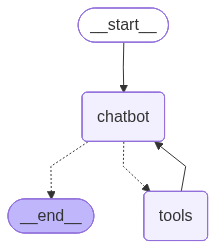

In [12]:
memory = MemorySaver()

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# config = {"configurable": {"thread_id": "10"}}

# async def chat(user_input: str, history):
#     result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
#     return result["messages"][-1].content

# gr.ChatInterface(chat, type="messages").launch()

In [14]:
# import asyncio

# config = {"configurable": {"thread_id": "10"}}

# def chat(user_input: str, history):
#     try:
#         loop = asyncio.get_event_loop()
#     except RuntimeError:
#         loop = asyncio.new_event_loop()
#         asyncio.set_event_loop(loop)
    
#     result = loop.run_until_complete(
#         graph.ainvoke(
#             {"messages": [{"role": "user", "content": user_input}]}, 
#             config=config
#         )
#     )
#     return result["messages"][-1].content

# gr.ChatInterface(chat, type="messages").launch()

In [15]:
import asyncio

config = {"configurable": {"thread_id": "10"}}

def chat(user_input: str, history):
    """Synchronous wrapper that properly handles async in Jupyter threads"""
    # Create a new event loop for this thread
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    
    try:
        result = loop.run_until_complete(
            graph.ainvoke(
                {"messages": [{"role": "user", "content": user_input}]}, 
                config=config
            )
        )
        return result["messages"][-1].content
    finally:
        loop.close()

# Launch Gradio
gr.ChatInterface(chat, type="messages").launch()

Exception in thread Thread-8 (run):
Traceback (most recent call last):
  File "/Users/pkiszczak/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/Users/pkiszczak/projects/learning/agents/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/pkiszczak/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/pkiszczak/projects/learning/agents/.venv/lib/python3.12/site-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pkiszczak/projects/learning/agents/.venv/lib/python3.12/site-packages/nest_asyncio.py", line 26, in run
    loop = asyncio.get_event_loop()
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Us

KeyboardInterrupt: 